# ULMFiT Language Model for Malay Language

## The Project

### Background

_This work is part of my project while studying [fast.ai's 2018 edition of Cutting Edge Deep Learning for Coders, Part 2](http://course.fast.ai/part2.html) course._

I took this opportunity to implement [Universal Language Model Fine-tuning for Text Classification (ULMFiT) paper](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html) in different languages together with the fast.ai community. fast.ai will soon launch a [model zoo with pre-trained language models for many languages](http://forums.fast.ai/t/language-model-zoo-gorilla/14623). You can learn more about ULMFiT in lesson 4 and lesson 10. What I learned from lesson 10 ([my notes](https://cedrickchee.gitbook.io/knowledge/courses/fast.ai/deep-learning-part-2-cutting-edge-deep-learning-for-coders/2018-edition/lesson-10-transfer-learning-nlp)) is:
- how pre-training a full language model from scratch can greatly surpass previous approaches based on simple word vectors
- transfer learning for NLP by using this language model to show a new state of the art result in text classification, in some sense like [NLP's ImageNet moment has arrived](http://ruder.io/nlp-imagenet/)

---

### Project Goal

The goal of this project is to train Malay word embeddings using the fast.ai version of [AWD-LSTM Language Model](https://arxiv.org/abs/1708.02182) by Salesforce Research—basically LSTM with dropouts—with data from [Wikipedia](https://dumps.wikimedia.org/mswiki/20180901/mswiki-20180901-pages-articles.xml.bz2) (last updated Sept 2, 2018). The AWD-LSTM language model achieved the state of the art performance on the English language.

Using 90/10 train-validation split, I achieved perplexity of **29.30245 with 60,002 embeddings at 400 dimensions**, compared to state-of-the-art as of June 12, 2018 at **40.68 for English WikiText-2 by [Yang et al (2017)](https://arxiv.org/abs/1711.03953)** and **29.2 for English WikiText-103 by [Rae et al (2018)](https://arxiv.org/abs/1803.10049)**. To the best of my knowledge, there is no comparable research in Malay language at the point of writing (Sept 21, 2018).

My workflow is as follows:
- Perform 90/10 train-validation split
- Minimal text cleaning and tokenization using our own tokenizer
- Train language model
- Evaluate model based on perplexity and eyeballing
- Get embeddings of dataset from train set

**Pre-trained model**

You can download the files from [Google Drive](https://drive.google.com/drive/folders/1p5fsrD97iRD-Vz6C_ae5fo4c5wY0KrJd?usp=sharing):
- Weights for the pre-trained model (lm_malay_final.h5.tar.gz)
    - Uncompress and put the weights (.h5 file) into `{project_root}/data/models/`.
- Index-to-word mapping (itos.pkl.tar.gz)
    - Uncompress and put the pickled objects (.pkl files) into `{project_root}/data/model/malay/tmp/`.
- Pre-processed training dataset of Malay Wikipedia:
    - tokenized training text data (tok_trn.npy.tar.gz)
    - tokenized validation text data (tok_val.npy.tar.gz)
    - indexed representation of train set (trn_ids.npy.tar.gz)
    - indexed representation of validation set (val_ids.npy.tar.gz)
    - Uncompress and put the numpy array binary (.npy files) into `{project_root}/data/model/malay/tmp/`.

Note:

The weights (model state dict) and the optimizer state for the model were saved at the end of the training.

_Note: the model was last trained on 2018-09-22 and the weights last updated on 2018-09-22._

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import html
import numpy as np
import pandas as pd

from fastai.text import *

# Standardize data format

In [3]:
BOS = "xbos"  # beginning-of-sentence tag
FLD = "xfld"  # data field tag

DATA_PATH = "data"
EXTR_PATH = pathlib.Path(f"{DATA_PATH}/wiki_extr/ms")

In [4]:
LM_PATH = Path(f"{DATA_PATH}/model/malay/")
LM_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
LANG_FILENAMES = [str(f) for f in EXTR_PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

232


['data/wiki_extr/ms/AB/wiki_65',
 'data/wiki_extr/ms/AB/wiki_11',
 'data/wiki_extr/ms/AB/wiki_62',
 'data/wiki_extr/ms/AB/wiki_84',
 'data/wiki_extr/ms/AB/wiki_23']

In [43]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))

LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [44]:
LANG_TEXT.head()

,id,text,title,url
0,666100,Senarai penyakit anjing\n\nSenarai penyakit an...,Senarai penyakit anjing,https://ms.wikipedia.org/wiki?curid=666100
1,666132,"Son\n\nSon, adalah satu siri televisyen Turki ...",Son,https://ms.wikipedia.org/wiki?curid=666132
2,666144,Kanashiki Amefuri / Adam to Eve no Dilemma\n\n...,Kanashiki Amefuri / Adam to Eve no Dilemma,https://ms.wikipedia.org/wiki?curid=666144
3,666153,"Bulakan, Cibeber\n\nBulakan merupakan sebuah K...","Bulakan, Cibeber",https://ms.wikipedia.org/wiki?curid=666153
4,666155,"Cibeber, Cibeber, Cilegon\n\nCibeber merupakan...","Cibeber, Cibeber, Cilegon",https://ms.wikipedia.org/wiki?curid=666155


In [45]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT["text"] = LANG_TEXT["text"].apply(lambda x: split_title_from_text(x))

In [46]:
LANG_TEXT.head()

,id,text,title,url
0,666100,Senarai penyakit anjing ialah pilihan penyakit...,Senarai penyakit anjing,https://ms.wikipedia.org/wiki?curid=666100
1,666132,"Son, adalah satu siri televisyen Turki yang di...",Son,https://ms.wikipedia.org/wiki?curid=666132
2,666144,Kanashiki Amefuri / Adam to Eve no Dilemma (悲し...,Kanashiki Amefuri / Adam to Eve no Dilemma,https://ms.wikipedia.org/wiki?curid=666144
3,666153,Bulakan merupakan sebuah Kelurahan yang terlet...,"Bulakan, Cibeber",https://ms.wikipedia.org/wiki?curid=666153
4,666155,Cibeber merupakan sebuah desa yang terletak da...,"Cibeber, Cibeber, Cilegon",https://ms.wikipedia.org/wiki?curid=666155


In [47]:
LANG_TEXT.to_csv(f"{LM_PATH}/wiki_malay_corpus.csv", index=False)

In [48]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/wiki_malay_corpus.csv")

In [49]:
LANG_TEXT = LANG_TEXT.assign(length = 0)
LANG_TEXT.columns = ["id", "text", "title", "url", "length"]
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[["labels", "text", "length"]])

In [50]:
LANG_TEXT.head()

,labels,text,length
0,0,Senarai penyakit anjing ialah pilihan penyakit...,0
1,0,"Son, adalah satu siri televisyen Turki yang di...",0
2,0,Kanashiki Amefuri / Adam to Eve no Dilemma (悲し...,0
3,0,Bulakan merupakan sebuah Kelurahan yang terlet...,0
4,0,Cibeber merupakan sebuah desa yang terletak da...,0


In [51]:
LANG_TEXT["length"] = LANG_TEXT["text"].str.len()
LANG_TEXT = LANG_TEXT.sort_values(by=["length"], ascending=False)

In [52]:
LANG_TEXT.head()

,labels,text,length
298556,0,"Dalam agama Islam, Asmaul Husna () merupakan s...",200069.0
287674,0,Tasbih Cinta merupakan sebuah Drama lipur lara...,154934.0
289705,0,Ketuanan Melayu merupakan kontrak sosial yang ...,101706.0
315332,0,Dato' Sri Siti Nurhaliza binti Tarudin (Jawi: ...,98675.0
95126,0,Kebebasan beragama di Malaysia adalah tertaklu...,94949.0


In [53]:
LANG_TEXT.to_csv(f"{LM_PATH}/wiki_malay_corpus_sorted_by_len.csv", index=False)

In [134]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/wiki_malay_corpus_sorted_by_len.csv")

In [135]:
len(LANG_TEXT)

319374

In [136]:
LANG_TEXT.head()

,labels,text,length
0,0,"Dalam agama Islam, Asmaul Husna () merupakan s...",200069.0
1,0,Tasbih Cinta merupakan sebuah Drama lipur lara...,154934.0
2,0,Ketuanan Melayu merupakan kontrak sosial yang ...,101706.0
3,0,Dato' Sri Siti Nurhaliza binti Tarudin (Jawi: ...,98675.0
4,0,Kebebasan beragama di Malaysia adalah tertaklu...,94949.0


In [137]:
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 10]

In [138]:
LANG_TEXT = LANG_TEXT.iloc[0:1000000]

In [139]:
len(LANG_TEXT)

316081

# Some statistics of Malay Wikipedia

### Number of documents

In [140]:
print(LANG_TEXT["text"][:10])
LANG_TEXT.shape

0    Dalam agama Islam, Asmaul Husna () merupakan s...
1    Tasbih Cinta merupakan sebuah Drama lipur lara...
2    Ketuanan Melayu merupakan kontrak sosial yang ...
3    Dato' Sri Siti Nurhaliza binti Tarudin (Jawi: ...
4    Kebebasan beragama di Malaysia adalah tertaklu...
5    England sudah dihuni manusia sejak lebih darip...
6    Perang Bosnia merupakan sebuah konflik bersenj...
7    Masakan Zaman Pertengahan termasuk makanan, ta...
8    Perang Vietnam, ada kalinya disebut juga "Pera...
9    Operasi Market-Garden adalah satu operasi sera...
Name: text, dtype: object


(316081, 3)

### Number of words in all the documents

In [141]:
LANG_TEXT["text"].apply(lambda x: len(x.split(" "))).sum()

26509826

### Number of unique tokens across documents

In [142]:
len(set("".join(LANG_TEXT["text"].values).split(" ")))

1742401

## Text processing

We perform the following minimal text processing:

- Remove html tags
- The token `xbos` is used to note start of a text since we will be chaining them together for the language model training.

### Clean plain text

In [155]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

### Tokenize

In [156]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f"\n{BOS} {FLD} 1 " + df[n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)):
        texts += f" {FLD} {i-n_lbls} " + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Create validation set

In [145]:
# Split the data into train and validation sets
# Splitting 10% for validation.
trn_texts, val_texts = sklearn.model_selection.train_test_split(LANG_TEXT, test_size=0.1)

In [166]:
len(trn_texts), len(val_texts)

(284472, 31609)

In [149]:
np.random.seed(42)

trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx, :] # sort things randomly
df_val = val_texts.iloc[val_idx, :] # sort things randomly

df_trn.columns = ["labels", "text", "length"]
df_val.columns = ["labels", "text", "length"]

df_trn.to_csv(LM_PATH / "train.csv", header=False, index=False)
df_val.to_csv(LM_PATH / "test.csv", header=False, index=False) # saving the data in our new format to disk

In [150]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH / "train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH / "test.csv", header=None, chunksize=chunksize)

## Data Preparation

We write a simple custom function to perform tokenization. Out of 24,911,449 tokens from all of training set, we chose 60,000 for the vocabulary size (plus one for unknown and another for padding) of tokens which are not rare words (appeared more than twice and not typos) in the training set.

In [158]:
# Finally, tokenize text data
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3


### Data loader

In [159]:
# Create a tmp directory to store the upcoming numpy arrays
(LM_PATH / "tmp").mkdir(exist_ok=True)

# Save the train and validation tokens in the tmp directories
np.save(LM_PATH / "tmp" / "tok_trn.npy", tok_trn)
np.save(LM_PATH / "tmp" / "tok_val.npy", tok_val)

In [160]:
tok_trn = np.load(LM_PATH / "tmp" / "tok_trn.npy")
tok_val = np.load(LM_PATH / "tmp" / "tok_val.npy")

In [161]:
# Sanity check: get the first 2 train tokens
tok_trn[:2]

array([list(['\n', 'xbos', 'xfld', '1', 'gräfenhainichen', 'merupakan', 'sebuah', 'bandar', 'terletak', 'di', 'daerah', 'wittenberg', ',', 'saxony', '-', 'anhalt', ',', 'jerman', '.', '\n ', 'xfld', '1', '94.0']),
       list(['\n', 'xbos', 'xfld', '1', '19', 'merupakan', 'tahun', 'biasa', 'yang', 'bermula', 'pada', 'hari', 'ahad', 'dalam', 'kalendar', 'gregory', '.', '\n', '<', 'br', 'clear', '=', 'all', '>', '\n ', 'xfld', '1', '92.0'])],
      dtype=object)

In [162]:
# Get the Counter object from all the splitted files.
# Identify the most common tokens
freq = Counter(p for o in tok_trn for p in o) 
freqs = pd.DataFrame.from_dict(freq, orient="index")
freqs.sort_values(0, ascending=False).head(25)

,0
",",1102901
.,999701
yang,548167
di,532424
dan,509869
1,465667
xfld,448944
\n,403986
"""",378261
-,355521


In [163]:
# Sanity check
len([p for o in tok_trn for p in o])

24911449

In [164]:
cnt = []
for i in range(49):
    row_cnt = freqs[freqs[0]>=i+1].shape[0]
    cnt.append(row_cnt)

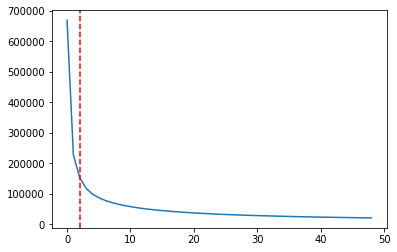

In [165]:
plt.plot(cnt)
plt.axvline(x=2, color="red", linestyle="--")

 ## Numericalize the text

We trained the language model based on 224,472 texts and validated on 31,609 texts from Malay Wikipedia using various tricks detailed in the [ULMFiT paper](https://arxiv.org/abs/1801.06146). The validation perplexity is 29.30245.

In [167]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

In [168]:
itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq] # getting rid of the rare words
itos.insert(0, "_pad_")
itos.insert(0, "_unk_") # itos is the list of all the strings in the vocab

In [169]:
# Creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

60002

In [170]:
# Creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [171]:
# Saving our indexed representation of our dataset to disk.
# We also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH / "tmp" / "trn_ids.npy", trn_lm)
np.save(LM_PATH / "tmp" / "val_ids.npy", val_lm)
pickle.dump(itos, open(LM_PATH / "tmp" / "itos.pkl", "wb"))

In [9]:
# Loading the indexed representation of our dataset from disk.
# We also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH / "tmp" / "trn_ids.npy")
val_lm = np.load(LM_PATH / "tmp" / "val_ids.npy")
itos = pickle.load(open(LM_PATH / "tmp" / "itos.pkl", "rb"))

In [10]:
# Check vocabulary size
vocab_size = len(itos)
trn_set_size = len(trn_lm)
val_set_size = len(val_lm)
vocab_size, trn_set_size, val_set_size

(60002, 224472, 31609)

In [11]:
# Sanity check
trn_lm[:2]

array([list([9, 13, 8, 7, 0, 17, 19, 58, 23, 5, 43, 33863, 2, 3841, 11, 7682, 2, 146, 3, 24, 8, 7, 1675]),
       list([9, 13, 8, 7, 700, 17, 25, 298, 4, 225, 12, 119, 2533, 14, 978, 1386, 3, 9, 687, 1835, 2184, 669, 1215, 648, 24, 8, 7, 1587])],
      dtype=object)

# Model Setup

In [174]:
# We train from scratch, so these are unused

# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

# PRE_PATH = LM_PATH / "models" / "wt103"
# PRE_LM_PATH = PRE_PATH / "fwd_wt103.h5"

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)
# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)
# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [25]:
em_sz = 400  # size of each embedding vector
nh = 1150    # number of hidden activations per layer
nl = 3       # number of layers

wd = 1e-7
bptt = 70
bs = 64
# opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.3

In [26]:
# if you're overfitting, increase this. Underfitting? decrease this.
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * weight_factor

In [27]:
%time
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(DATA_PATH, pad_idx=1, n_tok=vocab_size, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [28]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [42]:
# AWD-LSTM network
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)>

### Train

**Hyper-parameter search**

Properly setting the hyper-parameters of a neural network can be challenging, thankfully, there are some technique that can help.

We will speed up training using Leslie Smith's work on 1cycle policy that he described the [super-convergence] phenomenon in this [paper](https://arxiv.org/abs/1708.07120). Here's an [application of super-convergence to win the DAWNBench challenge](http://www.fast.ai/2018/04/30/dawnbench-fastai/).

Based on my own experiments with this method previously, the AWS-LSTM model converged faster, instead of 15 epochs, now it takes just 10 epochs.

We will be using an [implementation of this method](http://forums.fast.ai/t/the-1cycle-policy-an-experiment-that-investigate-super-convergence-phenomenon-described-in-leslie-smiths-research/14737):
- A simple guide on how to use 1cycle policy [Cyclical Learning Rate (CLR)](http://forums.fast.ai/t/using-use-clr-beta-and-new-plotting-tools/14702)
- Some [tips on super-convergence(ish) on WikiText-2](http://forums.fast.ai/t/super-convergence-ish-on-wikitext-2/17091), a similar LM task like ours.

In [18]:
# Find learning rate
learner.lr_find2(num_it=500)

  9%|▉         | 500/5559 [09:32<1:32:51,  1.10s/it, loss=7.94]

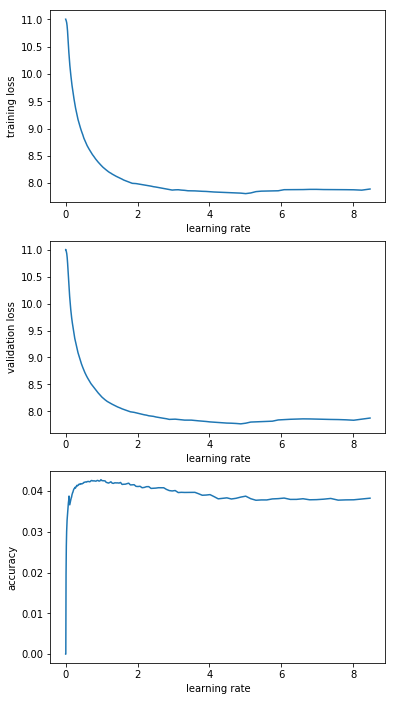

In [23]:
learner.sched.plot()

In [29]:
# Set learning rate
lr = 8

In [30]:
learner.fit(lr, 1, wds=wd, cycle_len=10, use_clr=(10,33,0.95,0.85), best_save_name='best_lm_malay_1cycle')

epoch      trn_loss   val_loss   accuracy                       
    0      4.114716   3.936571   0.367859  
    1      3.83864    3.711561   0.382893                       
    2      3.669321   3.603781   0.391633                       
    3      3.63252    3.560706   0.394518                       
    4      3.478959   3.513905   0.399009                       
    5      3.518267   3.480469   0.401523                       
    6      3.409158   3.465206   0.402808                       
    7      3.426483   3.437133   0.405097                       
    8      3.296175   3.409095   0.409595                       
    9      3.185208   3.377671   0.413643                       


[array([3.37767]), 0.41364255045710613]

Visualize loss history and learning rate history

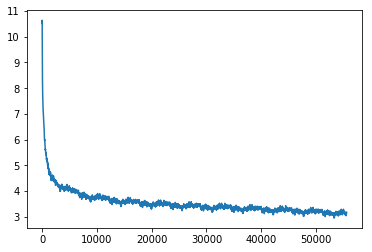

In [35]:
learner.sched.plot_loss()

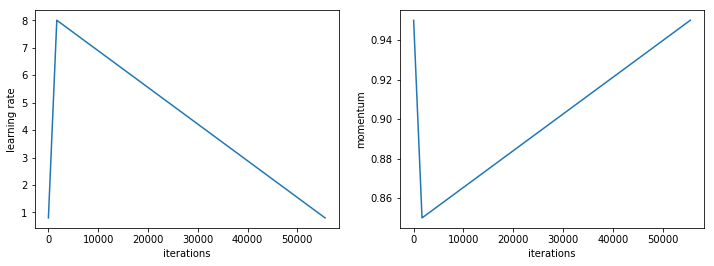

In [36]:
learner.sched.plot_lr()

#### Save weights

In [33]:
learner.save('lm_malay_final')

In [34]:
learner.save_encoder('lm_malay_enc_final')

#### Results

Let's see how our model did. Losses after 10 epochs:
- Training: 3.185208
- Validation: **3.377671**

In [32]:
np.exp(3.377671)

29.30244618263257

**Analysis**:

The **perplexity** of this language model after 10 epochs is **29.30245**.

It took me ~1 hour 24 minutes (5016.09s) to train 1 epoch on one Tesla K80 GPU, roughly 1.1 iteration/s. The full training took me ~14 hours.

## Evaluate

### Generate text using the model

We perform eyeballing test by having the model "fill in the blanks".

In [38]:
# Load model from saved weights
learner.load('lm_malay_final')

In [39]:
m = learner.model # initialized model
m.eval() # ensure you switch your model to inference mode
m[0].bs = 1 # set batch size to 1

In [43]:
# Load the index-word mapping from the picked file on disk to help us convert the indexes to words.
itos = pickle.load(open(LM_PATH / "tmp" / "itos.pkl", "rb"))

# String to index lambda function
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

60002

In [44]:
# Utility functions

def gen_text(ss, topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]

    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss, nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        word = itos[pred_i.data[0]]
        if word != "xbos":
            result.append(word)
        else:
            break
        pred, *_ = m(pred_i[0].unsqueeze(0))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))

    return(result)

#### Inference

In [138]:
strings = [
    "Menara Petronas",
    "Dr Mahathir merupakan Perdana Menteri",
    "Tunku ialah Bapa Kemerdekaan",
    "Syarikat penerbangan",
    "Durian ialah buah",
    "P Ramlee ialah seorang",
    "Pemenang badminton Piala Thomas",
    "Lee Chong Wei dan badminton",
    "Jurulatih Rashid Sidek",
    "Pokok getah",
    "Industri kelapa sawit di Malaysia",
    "Penyelidikan minyak sawit",
    "Negara terbesar di Asia Tenggara ialah",
    "Proton Saga adalah",
    "Penyanyi terkenal"
]

In [139]:
for s in strings:
    print(f"{s}... \n{generate_sentences(s.lower(), 80)}\n")

Menara Petronas... 
menara petronas. 
 pada tahun 2005, sebuah syarikat yang dikenali sebagai t_up petronas, yang dimiliki oleh t_up petronas, telah membeli sebuah syarikat yang dimiliki oleh t_up petronas, t_up petronas. pada tahun 2008, t_up petronas membeli saham mereka daripada t_up petronas, dan t_up petronas, dan t_up petronas, dan t_up petronas, dan t_up petronas, dan t_up petronas, dan t_up petronas, yang telah membeli saham mereka pada tahun 2008. t_up

Dr Mahathir merupakan Perdana Menteri... 
dr mahathir merupakan perdana menteri malaysia yang pertama. beliau juga merupakan seorang ahli parlimen bagi kawasan t_up dun t_up n53. beliau juga merupakan ahli parlimen bagi kawasan t_up dun t_up n53. beliau juga merupakan ahli parlimen bagi kawasan t_up dun t_up n53. beliau juga merupakan ahli parlimen bagi kawasan t_up dun t_up n53. beliau juga merupakan ahli parlimen bagi kawasan t_up dun t_up n53. beliau juga merupakan ahli parlimen bagi kawasan bukit gelugor, negeri sembilan. b

### Embeddings

We extract the embedding layer of the encoder to be used in the same manner as word2vec. We can also create sentence vector by summing or averaging the vectors. For more details about word2vec use cases, see word2vec_examples.ipynb.

#### Extract

In [140]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

In [148]:
malay2vec = pd.DataFrame(emb_np)
new_itos = itos
# replace space with token
new_itos[2] = '_space_'
# replace space for named entities with _
new_itos = [re.sub(' ', '_', i) for i in new_itos]
malay2vec.index = new_itos
malay2vec.iloc[200:210]

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
semua,0.013038,0.515365,0.050658,0.403895,-0.076790,-0.274187,-0.294301,-0.482214,-0.942632,-0.382407,...,0.000483,0.049201,-0.237344,-0.195282,0.318259,-0.085800,-0.082405,-0.008426,-0.548818,-0.450443
kanak,-0.261232,0.187345,0.054948,-0.388966,0.347622,0.906619,-0.085901,-0.067504,-0.227947,0.385188,...,0.133744,0.541352,-0.151185,0.144295,0.467201,0.060089,0.736018,0.356920,0.567058,-0.463647
album,0.493681,-0.060911,-0.029997,0.046737,-0.580396,0.530397,-0.035759,0.317195,-0.029852,0.295080,...,0.263408,-0.229109,0.182056,-0.561614,-0.144355,-0.297672,-0.030824,0.462025,0.147016,0.053593
menteri,-0.222996,-0.038149,0.061630,-0.323144,-0.102095,0.199310,-0.400978,-0.040864,-0.019013,-0.120582,...,0.412610,0.142238,-0.350635,0.059112,-0.300906,0.396439,0.035477,0.269761,-0.146999,-0.197764
turut,-0.314148,-0.329103,0.084600,0.258733,-0.126275,-0.426062,-0.482648,-0.129092,0.201955,0.143144,...,-0.096362,-0.009566,-0.645949,0.033635,-0.120077,0.654878,-0.348052,0.138207,-0.021835,-0.045728
kira,-0.989307,-0.055768,0.138539,-0.709911,-0.174012,-0.861263,-0.491223,0.044874,-0.403155,0.109385,...,0.157908,-0.044533,0.267241,-0.251010,-0.141131,-0.171218,0.155060,-0.295976,0.203567,-0.208005
murid,0.248733,-0.059398,-0.023560,-0.273422,-0.298870,0.082709,-0.414381,0.048601,-0.398422,0.156399,...,0.035820,-0.110192,0.296525,0.256502,-0.831308,-0.100444,-0.141868,0.223650,-0.933487,0.428067
kuala,0.151282,-0.164024,-0.214619,-0.244270,-0.234031,-0.298997,0.021982,0.546422,0.604748,-0.260872,...,-0.326803,0.072062,-0.017195,0.266519,0.331591,-0.068582,0.175815,0.104983,0.110367,0.049074
semula,0.125103,-0.197420,0.751799,-0.990424,-0.583707,0.293708,-0.224855,-0.778633,-0.698253,-0.438961,...,-0.231747,0.037555,0.303921,-0.279731,-0.914102,0.339698,0.337318,0.274428,-0.103200,0.126072
perempuan,0.344372,0.385741,-0.095603,0.161351,0.259355,0.608875,-0.228196,-0.217302,-0.557234,0.143539,...,0.383469,-0.132593,0.077143,0.672117,-0.278821,0.018481,-0.199514,0.894665,0.157668,0.372751


In [151]:
malay2vec.to_csv(f"{LM_PATH}/malay2vec_embeddings.csv", sep=" ", header=False, line_terminator="\n")
malay2vec.shape

(60002, 400)

In [ ]:
# from gensim.models import KeyedVectors

# model = KeyedVectors.load_word2vec_format(f"{LM_PATH}/malay2vec.csv", binary=False,
#                                           unicode_errors = "ignore")

In [ ]:
# model.save_word2vec_format(f'{LM_PATH}/malay2vec.bin', None, True)